# **Climate Forecasting | LSTM | Time series**

<img height=1000 width=800 src="https://science.nasa.gov/wp-content/uploads/2023/12/climateprojection_768_80.jpg" />

## **Libraries**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv
/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTest.csv


In [2]:
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style("whitegrid")
import plotly.express as px
import plotly.io as pio 
import plotly.graph_objects as go 
import math 
from datetime import timedelta 

from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error , mean_absolute_error 

import keras 
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential 
from keras.callbacks import EarlyStopping 

## **Preprocessing and Visualization**

In [3]:
df = pd.read_csv("/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv", parse_dates = True, index_col = "date")
df

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...
2016-12-28,17.217391,68.043478,3.547826,1015.565217
2016-12-29,15.238095,87.857143,6.000000,1016.904762
2016-12-30,14.095238,89.666667,6.266667,1017.904762


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1462 non-null   float64
 1   humidity      1462 non-null   float64
 2   wind_speed    1462 non-null   float64
 3   meanpressure  1462 non-null   float64
dtypes: float64(4)
memory usage: 57.1 KB


In [5]:
temp = go.Scatter(x=df.index, y=df['meantemp'], mode='lines', name='Temperature')

# Layout settings
layout = go.Layout(
    title='Mean Temperature',
    xaxis_title='date',
    yaxis_title='meantemp',
    legend=dict(x=0, y=1.0),
    margin=dict(l=80, r=80, t=40, b=40),
    height=500,
    width=1100,
)

# Combine the traces and layout
fig = go.Figure(data=temp, layout=layout)

# Display the plot
pio.show(fig)

In [6]:
humidity = go.Scatter(
    x=df.index, 
    y=df['humidity'], 
    mode='lines', 
    name='Humidity',
    line=dict(color='red')  
)

# Layout settings
layout = go.Layout(
    title='Humidity',
    xaxis_title='Date',
    yaxis_title='Humidity',
    legend=dict(x=0, y=1.0),
    margin=dict(l=80, r=80, t=40, b=40),
    height=500,
    width=1100,
)

# Combine the traces and layout
fig = go.Figure(data=[humidity], layout=layout)

# Display the plot
pio.show(fig)


In [7]:
wind_speed = go.Scatter(
    x=df.index, 
    y=df['wind_speed'], 
    mode='lines', 
    name='Wind Speed',
    line=dict(color='purple')  
)

# Layout settings
layout = go.Layout(
    title='Wind Speed',
    xaxis_title='Date',
    yaxis_title='Wind Speed',
    legend=dict(x=0, y=1.0),
    margin=dict(l=80, r=80, t=40, b=40),
    height=500,
    width=1100,
)

# Combine the traces and layout
fig = go.Figure(data=[wind_speed], layout=layout)

# Display the plot
pio.show(fig)

In [8]:
meanpressure = go.Scatter(
    x=df.index, 
    y=df['meanpressure'], 
    mode='lines', 
    name='Mean Pressure',
    line=dict(color='orange')  
)

# Layout settings
layout = go.Layout(
    title='Mean Pressure',
    xaxis_title='Date',
    yaxis_title='Mean Pressure',
    legend=dict(x=0, y=1.0),
    margin=dict(l=80, r=80, t=40, b=40),
    height=500,
    width=1100,
)

# Combine the traces and layout
fig = go.Figure(data=[meanpressure], layout=layout)

# Display the plot
pio.show(fig)

In [9]:
dataset = df["meantemp"]
df2 = pd.DataFrame(dataset)
df2.values.shape

(1462, 1)

In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df2).reshape(-1, 1))

In [11]:
train_size = int(len(data_scaled) * 0.75)
test_size = len(df2) - train_size 
print(train_size, "/", test_size)

1096 / 366


In [12]:
train_data = data_scaled[:train_size, 0:1]
train_data.shape 

(1096, 1)

In [13]:
x_train = []
y_train = []

for i in range(60, len(train_data)):
               x_train.append(train_data[i-60:i, 0])
               y_train.append(train_data[i, 0])

x_train = np.array(x_train)
y_train = np.array(y_train)


In [14]:
# Reshaping the input to 3D array [samples, time_steps, features].
x_train = np.reshape(x_train ,(x_train.shape[0], x_train.shape[1], 1))

## **LSTM Model**

In [15]:
model = Sequential([
    LSTM(50, return_sequences=True,input_shape = (x_train.shape[1], 1) ),
    LSTM(64, return_sequences= False),
    Dense(32),
    Dense(16),
    Dense(1)
    
])

model.compile(optimizer= "adamax", loss="mse", metrics=["mean_absolute_error"])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,465 (165.88 KB)

 Trainable params: 42,465 (165.88 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
EarlyStopping = EarlyStopping(monitor="loss", patience=15, restore_best_weights=True)
history= model.fit(x_train, y_train, epochs=100, batch_size=32,callbacks = [EarlyStopping])

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.1118 - mean_absolute_error: 0.2458
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0092 - mean_absolute_error: 0.0767
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0068 - mean_absolute_error: 0.0650
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0062 - mean_absolute_error: 0.0624
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0057 - mean_absolute_error: 0.0601
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0052 - mean_absolute_error: 0.0576
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0058 - mean_absolute_error: 0.0611
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0056 - mean_absolute_error: 0.0586
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0055 - mean_absolute_error: 0.0594
Epoch 10/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0053 - mean_absolute_error: 0.0571
Epoch 11/100
33/33 ━━━━━━━━━━━━

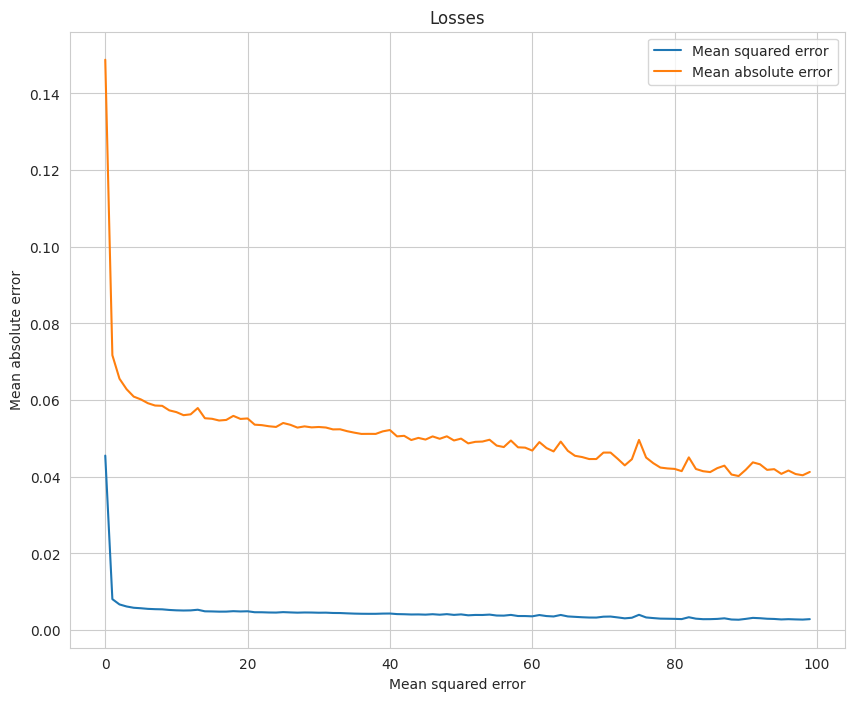

In [18]:
plt.figure(figsize=(10, 8))
plt.plot(history.history["loss"])
plt.plot(history.history["mean_absolute_error"])
plt.title("Losses")
plt.xlabel("Mean squared error")
plt.ylabel("Mean absolute error")
plt.legend(["Mean squared error", "Mean absolute error"])
plt.show()

In [19]:
test_data = data_scaled[train_size - 60:, :]
x_test = []
y_test = []

for i in range(60, len(test_data)):
               x_test.append(test_data[i-60:i, 0])
               y_test.append(test_data[i, 0])

x_train = np.array(x_test)
y_train = np.array(y_test)

In [20]:
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [21]:
x_test.shape , y_test.shape

((366, 60, 1), (366,))

In [22]:
predictions = model.predict(x_test)

predictions = scaler.inverse_transform(predictions)
predictions.shape

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


(366, 1)

In [23]:
y_test = scaler.inverse_transform([y_test])

RMSE = np.sqrt(np.mean( y_test - predictions )**2).round(2)
RMSE

0.39

In [24]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})
preds_acts

,Predictions,Actuals
0,14.764027,14.000000
1,14.337773,14.375000
2,14.133060,15.750000
3,14.435122,15.833333
4,14.803300,17.375000
...,...,...
361,16.452412,17.217391
362,16.750200,15.238095
363,16.331173,14.095238
364,15.594615,15.052632


In [25]:
y_train_flattened = y_train.flatten()

# Create a DataFrame with 'train' as the column name
train = pd.DataFrame(data=y_train_flattened, columns=['train'])

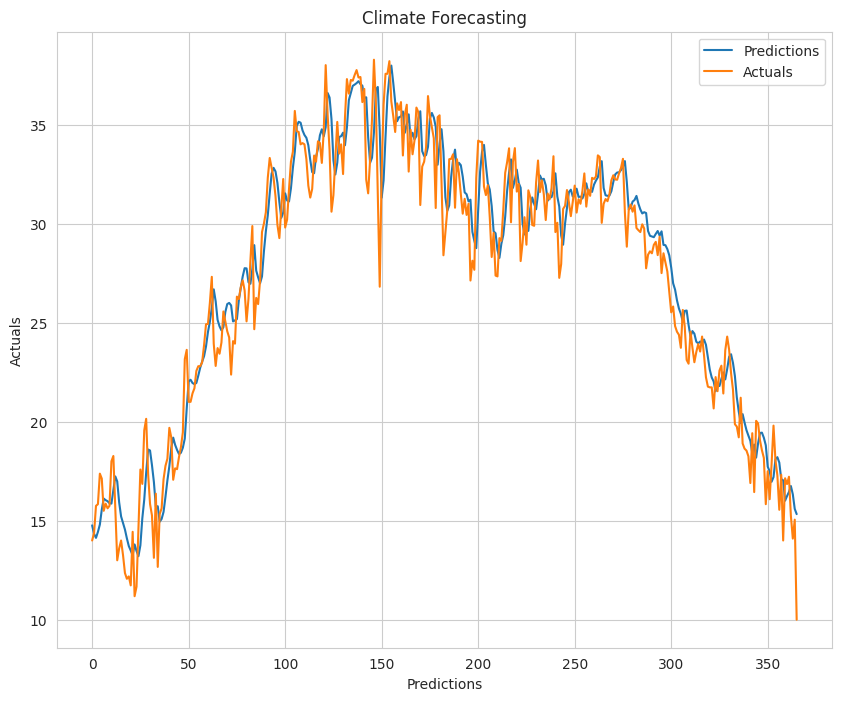

In [26]:
plt.figure(figsize=(10, 8))
plt.plot(preds_acts["Predictions"])
plt.plot(preds_acts["Actuals"])
plt.title("Climate Forecasting")
plt.xlabel("Predictions")
plt.ylabel("Actuals")
plt.legend(["Predictions", "Actuals"])
plt.show()

## **Temperature forecast for the next 50 days**

In [27]:
# Define the insert_end function
def insert_end(Xin, new_input):
    timestep = Xin.shape[1]  # Ensure timestep matches the input shape
    Xin[:, :-1, :] = Xin[:, 1:, :]  # Shift sequence
    Xin[:, -1, :] = new_input  # Insert new input at the end
    return Xin

# Forecast future values
future = 50
forcast = []
Xin = x_test[-1:, :, :]  # Initialize with the last input of the test set
time = []

for i in range(future):
    out = model.predict(Xin, batch_size=5)
    forcast.append(out[0])
    Xin = insert_end(Xin, out[0].reshape(1, 1, 1))  # Reshape for input
    time.append(pd.to_datetime(df.index[-1]) + timedelta(days=i))

# Convert forecasted output to numpy array and ensure correct shape
forcasted_output = np.array(forcast).reshape(-1, 1)  # Adjust shape as needed

# Apply inverse transformation (Ensure scaler is compatible with forecasted output)
forcasted_output = scaler.inverse_transform(forcasted_output)

# Convert forecasted output to DataFrame with appropriate column names
forcasted_output_df = pd.DataFrame(forcasted_output, columns=['meantemp'])  # Adjust columns if needed

# Convert `time` to DataFrame
date_df = pd.DataFrame(time, columns=['Date'])

# Concatenate date and forecasted output
df_result = pd.concat([date_df, forcasted_output_df], axis=1)

# Display the DataFrame
print(df_result.head())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

In [28]:
df_result.head(50)

,Date,meantemp
0,2017-01-01,15.331678
1,2017-01-02,15.294652
2,2017-01-03,15.311684
3,2017-01-04,15.345028
4,2017-01-05,15.376871
5,2017-01-06,15.402178
6,2017-01-07,15.421412
7,2017-01-08,15.429913
8,2017-01-09,15.428558
9,2017-01-10,15.421434


/tmp/ipykernel_24/1492327932.py:4: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.



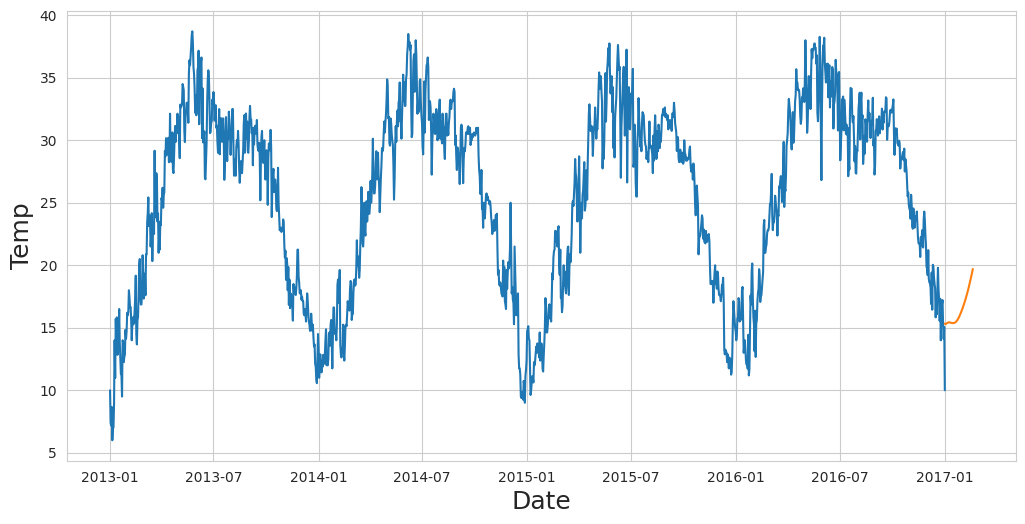

In [29]:
plt.figure(figsize=(20, 10))
plt.title('Next 30 Days')

plt.subplot(2, 2, 1)
plt.plot(df['meantemp'])
plt.plot(df_result.set_index('Date')[['meantemp']])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Temp' ,fontsize=18)

plt.tight_layout()
plt.show()